<a href="https://colab.research.google.com/github/gerpervaz/MNIST/blob/main/G_Perez_Vazquez_UA05_(MLP_using_MNIST_statistics_descriptors).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MLP using MNIST statistics descriptors**

Vamos a hacer uso si es posible de GPU

In [1]:
import tensorflow as tf

# Verificar si TensorFlow está utilizando la GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU")
else:
    print("TensorFlow is using the CPU")

Num GPUs Available:  1
TensorFlow is using the GPU


Importamos las librerias que vamos a utilizar

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Realizamos unas transformaciones para añadir ruido a la base de datos de entrenamiento

In [3]:
# Definir las transformaciones
def preprocess_image(image, label):
    image = tf.image.resize_with_crop_or_pad(image, 28, 28)
    image = tf.image.random_crop(image, size=[28, 28, 1])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [4]:
# Cargar el dataset MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


PREPROCESAMIENTO DE LA BASE DE DATOS

In [5]:
# Expandir las dimensiones del dataset para que tengan la forma (28, 28, 1)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Crear datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Aplicar las transformaciones a dichos datasets
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Mezclar y preparar los datos para el entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=60000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

Creamos una función de calcula des estadísticas descriptivas de cada imagen (media, desviación estándar, cuartiles 1 y 3), de cada fila de la matriz de 28x28, de cada columna, y de la diagonal principal.

In [6]:
# Calcular estadísticas descriptivas
def calculate_extended_statistics(images):
    x_means, y_means, diag_means = [], [], []
    x_stds, y_stds, diag_stds = [], [], []
    x_q1s, y_q1s, diag_q1s = [], [], []
    x_q3s, y_q3s, diag_q3s = [], [], []
    x_maxs, y_maxs, diag_maxs = [], [], []
    x_mins, y_mins, diag_mins = [], [], []

    for image in images:
        image = tf.squeeze(image).numpy()
        x_means.append(np.mean(image, axis=1))
        y_means.append(np.mean(image, axis=0))
        diag_means.append(np.mean(np.diag(image)))

        x_stds.append(np.std(image, axis=1))
        y_stds.append(np.std(image, axis=0))
        diag_stds.append(np.std(np.diag(image)))

        x_q1s.append(np.percentile(image, 25, axis=1))
        y_q1s.append(np.percentile(image, 25, axis=0))
        diag_q1s.append(np.percentile(np.diag(image), 25))

        x_q3s.append(np.percentile(image, 75, axis=1))
        y_q3s.append(np.percentile(image, 75, axis=0))
        diag_q3s.append(np.percentile(np.diag(image), 75))

        x_maxs.append(np.max(image, axis=1))
        y_maxs.append(np.max(image, axis=0))
        diag_maxs.append(np.max(np.diag(image)))

        x_mins.append(np.min(image, axis=1))
        y_mins.append(np.min(image, axis=0))
        diag_mins.append(np.min(np.diag(image)))

    # Convertir las listas a matrices numpy
    x_means = np.array(x_means).reshape(-1, 28)
    y_means = np.array(y_means).reshape(-1, 28)
    diag_means = np.array(diag_means).reshape(-1, 1)

    x_stds = np.array(x_stds).reshape(-1, 28)
    y_stds = np.array(y_stds).reshape(-1, 28)
    diag_stds = np.array(diag_stds).reshape(-1, 1)

    x_q1s = np.array(x_q1s).reshape(-1, 28)
    y_q1s = np.array(y_q1s).reshape(-1, 28)
    diag_q1s = np.array(diag_q1s).reshape(-1, 1)

    x_q3s = np.array(x_q3s).reshape(-1, 28)
    y_q3s = np.array(y_q3s).reshape(-1, 28)
    diag_q3s = np.array(diag_q3s).reshape(-1, 1)

    x_maxs = np.array(x_maxs).reshape(-1, 28)
    y_maxs = np.array(y_maxs).reshape(-1, 28)
    diag_maxs = np.array(diag_maxs).reshape(-1, 1)

    x_mins = np.array(x_mins).reshape(-1, 28)
    y_mins = np.array(y_mins).reshape(-1, 28)
    diag_mins = np.array(diag_mins).reshape(-1, 1)

    return (x_means, y_means, diag_means, x_stds, y_stds, diag_stds, x_q1s, y_q1s, diag_q1s, x_q3s, y_q3s, diag_q3s, x_maxs, y_maxs, diag_maxs, x_mins, y_mins, diag_mins)


Función para extraer características de cada dataset

In [7]:
def extract_features(dataset):
    x_means, y_means, diag_means = [], [], []
    x_stds, y_stds, diag_stds = [], [], []
    x_q1s, y_q1s, diag_q1s = [], [], []
    x_q3s, y_q3s, diag_q3s = [], [], []
    x_maxs, y_maxs, diag_maxs = [], [], []
    x_mins, y_mins, diag_mins = [], [], []
    labels = []

    for batch in dataset:
        images, label_batch = batch
        stats = calculate_extended_statistics(images)

        x_means.extend(stats[0])
        y_means.extend(stats[1])
        diag_means.extend(stats[2])

        x_stds.extend(stats[3])
        y_stds.extend(stats[4])
        diag_stds.extend(stats[5])

        x_q1s.extend(stats[6])
        y_q1s.extend(stats[7])
        diag_q1s.extend(stats[8])

        x_q3s.extend(stats[9])
        y_q3s.extend(stats[10])
        diag_q3s.extend(stats[11])

        x_maxs.extend(stats[12])
        y_maxs.extend(stats[13])
        diag_maxs.extend(stats[14])

        x_mins.extend(stats[15])
        y_mins.extend(stats[16])
        diag_mins.extend(stats[17])

        labels.extend(label_batch.numpy())

    return (np.array(x_means), np.array(y_means), np.array(diag_means), np.array(x_stds), np.array(y_stds), np.array(diag_stds), np.array(x_q1s), np.array(y_q1s), np.array(diag_q1s), np.array(x_q3s), np.array(y_q3s), np.array(diag_q3s), np.array(x_maxs), np.array(y_maxs), np.array(diag_maxs), np.array(x_mins), np.array(y_mins), np.array(diag_mins)), np.array(labels)



In [8]:
train_features, y_train = extract_features(train_dataset)
test_features, y_test = extract_features(test_dataset)

# Concatenar las características para formar el conjunto de características final
X_train_stats = np.hstack(train_features)
X_test_stats = np.hstack(test_features)

# Escalar las características
scaler = StandardScaler()
X_train_stats = scaler.fit_transform(X_train_stats)
X_test_stats = scaler.transform(X_test_stats)

# Convertir etiquetas a one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)



In [9]:
# Definir el modelo Softmax en TensorFlow con múltiples capas
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_stats.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [10]:
# Entrenar el modelo y almacenar el historial
history = model.fit(X_train_stats, y_train_one_hot, epochs=50, batch_size=32, validation_split=0.2)



Epoch 1/50
1500/1500 [==============================] - 8s 3ms/step - loss: 1.5691 - accuracy: 0.4458 - val_loss: 1.0677 - val_accuracy: 0.6495
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 1.2244 - accuracy: 0.5802 - val_loss: 0.9119 - val_accuracy: 0.7102
Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 1.1131 - accuracy: 0.6236 - val_loss: 0.8264 - val_accuracy: 0.7349
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 1.0375 - accuracy: 0.6523 - val_loss: 0.8007 - val_accuracy: 0.7442
Epoch 5/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.9956 - accuracy: 0.6684 - val_loss: 0.7509 - val_accuracy: 0.7558
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.9522 - accuracy: 0.6813 - val_loss: 0.7167 - val_accuracy: 0.7699
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.9242 - accuracy: 0.6895 - val_loss: 0.6861 - val_accuracy:

In [11]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_stats, y_test_one_hot)
print(f"Test Accuracy: {accuracy}")

# Generar el informe de clasificación
y_test_pred = np.argmax(model.predict(X_test_stats), axis=1)
print(classification_report(y_test, y_test_pred))

313/313 [==============================] - 1s 2ms/step - loss: 0.5578 - accuracy: 0.8226
Test Accuracy: 0.8226000070571899
313/313 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.98      0.98      0.98      1135
           2       0.71      0.69      0.70      1032
           3       0.85      0.59      0.70      1010
           4       0.85      0.82      0.84       982
           5       0.60      0.74      0.66       892
           6       0.84      0.83      0.83       958
           7       0.87      0.86      0.86      1028
           8       0.82      0.88      0.85       974
           9       0.79      0.86      0.82      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



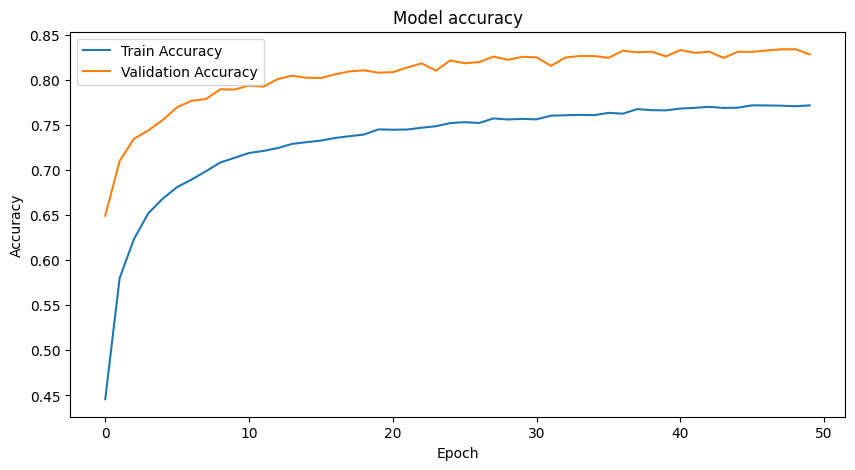

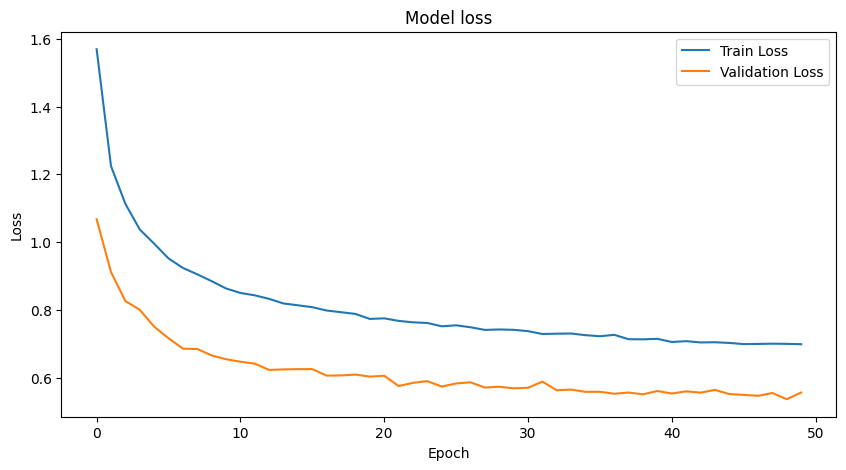

In [12]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
